In [165]:
# %pip install wordcloud

In [166]:
# %pip install geopandas matplotlib pycountry

In [167]:
#Imports des bibliothèques

# import pycountry
import random
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import geopandas as gpd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter

### Chargement des données + sélection des variables explicatives

In [168]:
# Chargement du dataset
df = pd.read_csv("anthems.csv")

In [169]:
#Informations générales


print("\n\nNombre d'observations et de variables")
print(df.shape)
print("\n\n------------------------------------------------------------------------")
print("\n\nTypes des variables")
print(df.dtypes)
print("\n\n------------------------------------------------------------------------")
print("\n\nValeurs manquantes (nulles)")
print(df.isnull().sum())
print("\n\n------------------------------------------------------------------------")
print("\n\nValeurs manquantes (na)")
print(df.isnull().sum())
print("\n\n------------------------------------------------------------------------")
print("\n\nCalculs de base")
print(df.describe())
print("\n\n------------------------------------------------------------------------")
print("\n\nInformations de base sur le dataset")
print(df.info())
print("\n\n------------------------------------------------------------------------")
print("Premières observations du dataframe")
print(df.head())



Nombre d'observations et de variables
(190, 5)


------------------------------------------------------------------------


Types des variables
Country      object
Alpha-2      object
Alpha-3      object
Continent    object
Anthem       object
dtype: object


------------------------------------------------------------------------


Valeurs manquantes (nulles)
Country      0
Alpha-2      1
Alpha-3      0
Continent    0
Anthem       0
dtype: int64


------------------------------------------------------------------------


Valeurs manquantes (na)
Country      0
Alpha-2      1
Alpha-3      0
Continent    0
Anthem       0
dtype: int64


------------------------------------------------------------------------


Calculs de base
        Country Alpha-2 Alpha-3 Continent  \
count       190     189     190       190   
unique      190     188     190         6   
top     Albania      CH     ALB    Africa   
freq          1       2       1        56   

                                       

In [170]:
# Supprimer la colonne 'Alpha-2' car une valeur nulle + redondante avec 'Alpha-3'
df.drop(columns=['Alpha-2'], inplace=True)

### Histogramme du nombre de pays par continent

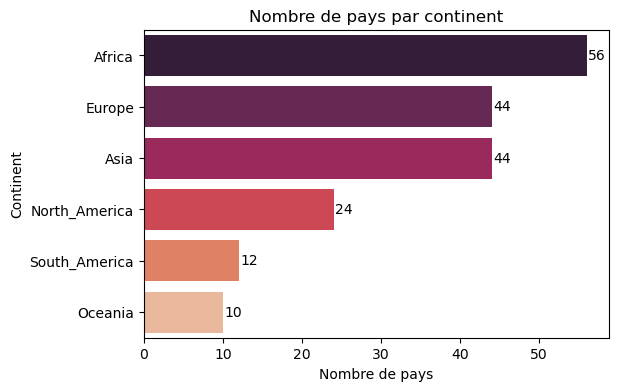

In [171]:
# Calcul du nombre de pays par continent
continent_counts = df['Continent'].value_counts()

# Trier les continents par nombre de pays
continent_counts_sorted = continent_counts.sort_values(ascending=False)

# Créer l'histogramme
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=continent_counts_sorted.values, y=continent_counts_sorted.index, palette='rocket')
plt.xlabel('Nombre de pays')
plt.ylabel('Continent')
plt.title('Nombre de pays par continent')

# Ajouter les annotations sur les barres
for i, (value, name) in enumerate(zip(continent_counts_sorted.values, continent_counts_sorted.index)):
    ax.text(value + 0.2, i, str(value), color='black', ha="left", va="center")

plt.show()

### Pie chart des fréquences du nombre de pays par continent

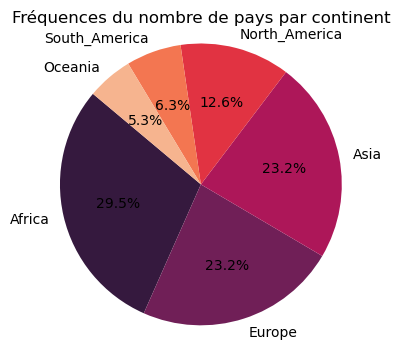

In [172]:
plt.figure(figsize=(4, 4))
plt.pie(continent_counts_sorted, labels=continent_counts_sorted.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('rocket', len(continent_counts_sorted)))
plt.title('Fréquences du nombre de pays par continent')
plt.axis('equal')
plt.show()

## 1- Pipeline de pré-traitement des textes

In [173]:
# tokenisation : division du texte en mots ou phrases
nltk.download('punkt')

# stopwords : mots vides sont des mots courants comme "and", "the", "is", etc., qui sont à supprimer dans le traitement du langage naturel
nltk.download('stopwords')

# Télécharge le corpus WordNet utilisé pour la lemmatisation 
# lemmatization : réduit les mots fléchis à leur forme de base ou lemme (par exemple, "running" devient "run").
nltk.download('wordnet')

# Fonction de prétraitement du texte (majuscule et ponctualtion)
def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Initialiser le lemmatizer et les stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Fonction de tokenisation et de lemmatisation
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Transformer les fonctions en transformateurs sklearn
preprocessing_transformer = FunctionTransformer(lambda x: pd.Series(x).apply(text_preprocessing))
lemmatization_transformer = FunctionTransformer(lambda x: pd.Series(x).apply(tokenize_and_lemmatize))

# Appliquer les transformations de prétraitement
df['cleaned_anthem'] = preprocessing_transformer.transform(df['Anthem'])
df['processed_anthem'] = lemmatization_transformer.transform(df['cleaned_anthem'])


pipeline = Pipeline([
    ('vectorization', TfidfVectorizer())
])

# Appliquer la vectorisation sur les hymnes traités
X = pipeline.fit_transform(df['processed_anthem'])

# Vectorisation : lors de la vectorisation avec des techniques comme TF-IDF, la fréquence d'un mot est pondérée en fonction de sa fréquence dans l'ensemble des documents (corpus) 
# et inversement proportionnelle à la fréquence des documents contenant ce mot. Par conséquent, même si chaque vecteur représente une observation individuelle, la pondération des 
# termes dépend de l'ensemble du corpus.

[nltk_data] Downloading package punkt to /Users/ophelie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ophelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ophelie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [174]:
# Convertir la matrice sparse en une matrice dense
X_dense = X.toarray()

# Optionnel : créer un DataFrame avec des noms de colonnes
feature_names = pipeline.named_steps['vectorization'].get_feature_names_out()
X_df = pd.DataFrame(X_dense, columns=feature_names)

# Afficher les premières lignes du DataFrame
# print(X_df.head())
print(X_df.shape)


(190, 3367)


## 2- Partitionnement k-means

### Déterminer le nombre optimal de clusters par la **méthode du coude**.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


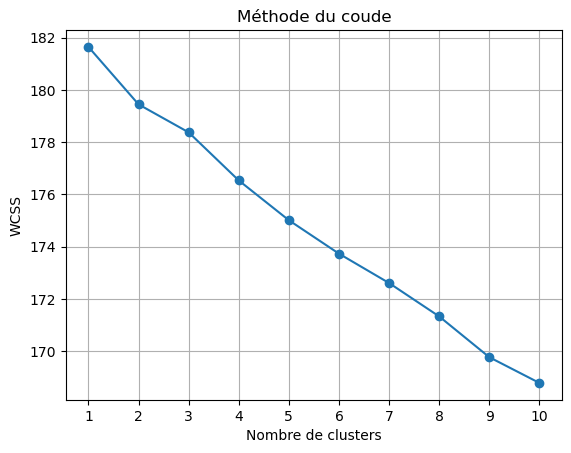

In [175]:
def plot_kmeans_elbow_method(X, max_clusters=10):
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Méthode du coude')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('WCSS')
    plt.xticks(np.arange(1, max_clusters + 1, step=1))  # Assure que les marques sur l'axe des x sont pour chaque valeur de k
    plt.grid(True)
    plt.show()

plot_kmeans_elbow_method(X)

Le graphique de la **méthode du coude** représente la somme des carrés des distances intra-cluster (WCSS - Within-Cluster Sum of Squares) en fonction du nombre de clusters. 

La WCSS mesure la somme des distances au carré entre chaque point et le centre de son cluster respectif.

Points clefs du graphique
- Diminution de la WCSS : On observe que la WCSS diminue à mesure que le nombre de clusters augmente. Cela est attendu, car ajouter plus de clusters réduit la distance moyenne entre les points et le centre du cluster.

- Point de Coude : Le but de la méthode du coude est d'identifier le point où la diminution de la WCSS commence à ralentir de manière significative. Ce point de coude est généralement considéré comme le nombre optimal de clusters, car il représente un bon compromis entre le nombre de clusters et la variance expliquée.

=> On a l'impression que la pente est quasiment la même tout le long de la courbe mais on observe un petit coude aux alentours de k=2 et k=3.
Le nombre optimal de cluster semble être k = 2.


### Déterminer le nombre optimal de clusters par la **méthode silhouette**.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

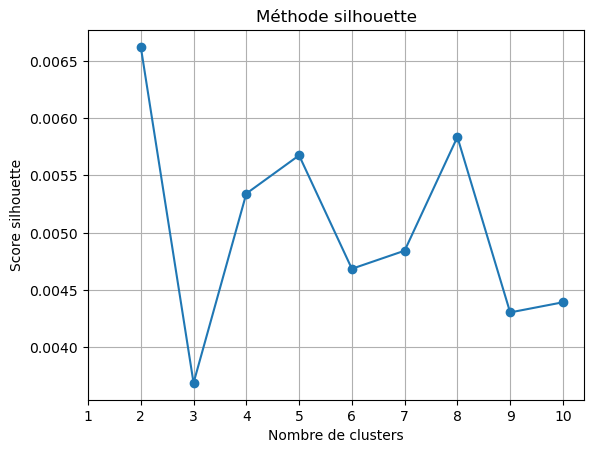

In [176]:
def plot_kmeans_silhouette_method(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)

    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Méthode silhouette')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score silhouette')
    plt.xticks(np.arange(1, max_clusters + 1, step=1))  # Assure que les marques sur l'axe des x sont pour chaque valeur de k
    plt.grid(True)
    plt.show()

plot_kmeans_silhouette_method(X)

Le score silhouette mesure la qualité du clustering. Il varie de -1 à 1, où un score proche de 1 indique que les points sont bien séparés en clusters distincts, un score proche de 0 indique que les points se trouvent entre deux clusters, et un score négatif indique que les points sont mal classés.

Le score silhouette suggère que k = 2 donne la meilleure séparation des clusters, suivi de k=8, k = 4 et k = 5 comme valeurs raisonnables avec des scores relativement élevés.

### Ajouter la variable cluster et fixer une valeur pour optimal_k

In [177]:

#! determine optimal_k 

optimal_k = 2  # choix d'apèrs les méthodes ci-dessus
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Représentations

#### Nuage de points en utilisant la PCA

In [178]:
# Connaitre le nombre de components pertinents pour visualiser les datas

   # Détermine le nombre optimal de composantes principales pour atteindre un seuil de variance cumulée donné.
def optimal_number_of_components(X_df, variance_threshold=0.8):

    # Appliquer TruncatedSVD
    svd = TruncatedSVD(n_components=min(X.shape[0], X.shape[1]-1))  # Assure que n_components <= min(n_obs, n_features)
    svd.fit(X)
    
    # Calcul de la variance expliquée cumulée
    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    
    # Trouver le nombre minimal de composantes pour atteindre le seuil de variance
    num_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    
    return num_components

n_components = optimal_number_of_components(X)
n_components

128

Même si les deux premières composantes principales (PC1 et PC2) n'expliquent pas la majorité de la variance, elles peuvent toujours fournir une vue utile des clusters dans les données. La visualisation des premières composantes principales peut aider à identifier des patterns et des clusters qui ne seraient pas immédiatement évidents autrement. Si les premières composantes principales montrent une bonne séparation des clusters, elles peuvent être utilisées pour des analyses ultérieures ou des visualisations intuitives.

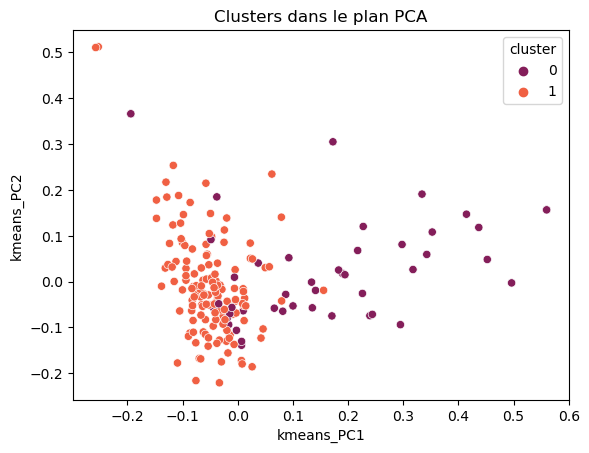

In [179]:
# Utiliser la PCA pour faire une première représentation des deux clusters et voir s'il y a une cohérence
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X.toarray())

#can change number here to change the PC => principal_components[:, 0]
df['kmeans_PC1'] = principal_components[:, 0]
df['kmeans_PC2'] = principal_components[:, 1]

def define_colors_palette(palette, clusters_number):
  return sns.color_palette(palette, clusters_number)

colors = define_colors_palette('rocket', optimal_k)

# Afficher le nuage de points de PC2 en fonction de PC1
sns.scatterplot(data=df, x='kmeans_PC1', y='kmeans_PC2', hue='cluster', palette=colors)
plt.title('Clusters dans le plan PCA')
plt.show()


#### Répartition des k clusters au sein des continents

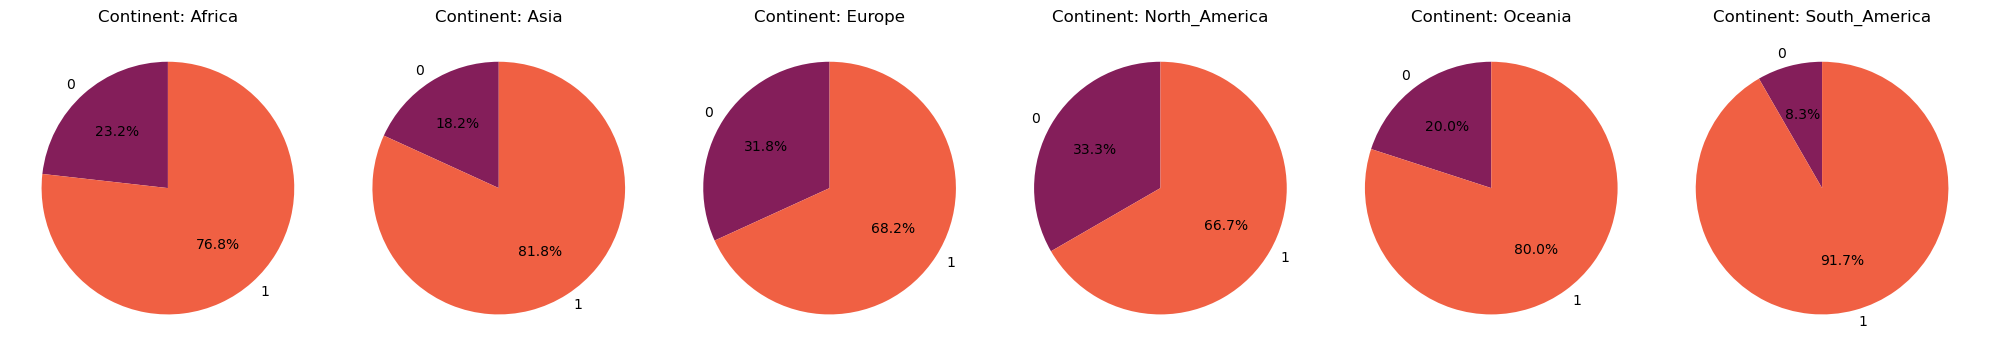

In [180]:
def plot_piecharts(df, unit_col_pie, freq_col_pie, num_cols, palette='rocket'):
    # Calculer la répartition des fréquences dans chaque unité
    unit_freq_counts = df.groupby([unit_col_pie, freq_col_pie]).size().unstack(fill_value=0)
    unit_freq_percentages = unit_freq_counts.apply(lambda x: x / x.sum(), axis=1)

    # Obtenir les couleurs de la palette spécifiée de seaborn
    colors = define_colors_palette(palette, len(unit_freq_percentages.columns))

    # Définir le nombre de graphiques par ligne
    num_units = len(unit_freq_percentages.index)
    num_rows = (num_units + num_cols - 1) // num_cols

    # Créer les pie charts pour chaque unité
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
    axes = axes.flatten()

    for i, unit in enumerate(unit_freq_percentages.index):
        ax = axes[i]
        unit_freq_percentages.loc[unit].plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, legend=False, colors=colors)
        ax.set_ylabel('')
        ax.set_title(f'{unit_col_pie}: {unit}')

    # Supprimer les axes non utilisés
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_piecharts(df, unit_col_pie='Continent', freq_col_pie='cluster', num_cols=6, palette='rocket')

#### Répartition des continents au sein des k clusters

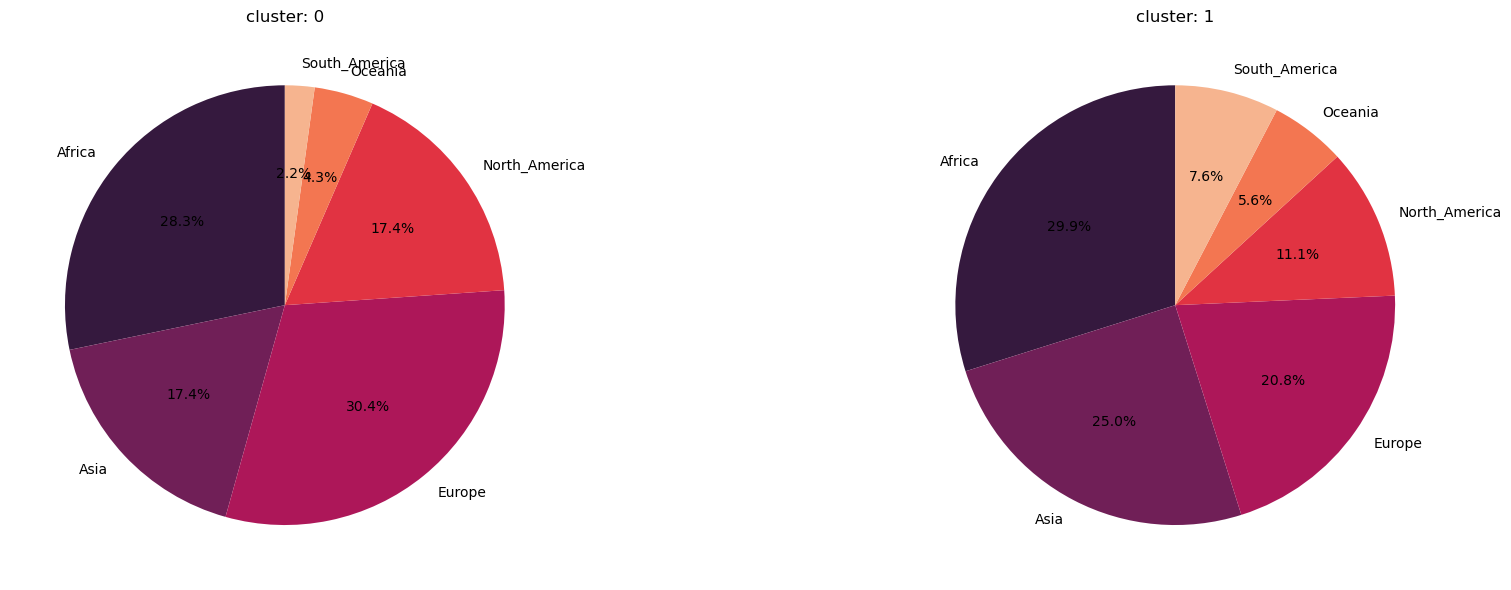

In [181]:
plot_piecharts(df, unit_col_pie='cluster', freq_col_pie='Continent', num_cols=optimal_k, palette='rocket')

#### Carte de la répartition des clusters dans le monde

/var/folders/1k/1sj3zxpx1x78x8blphwrrcrc0000gn/T/ipykernel_34610/4229449231.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


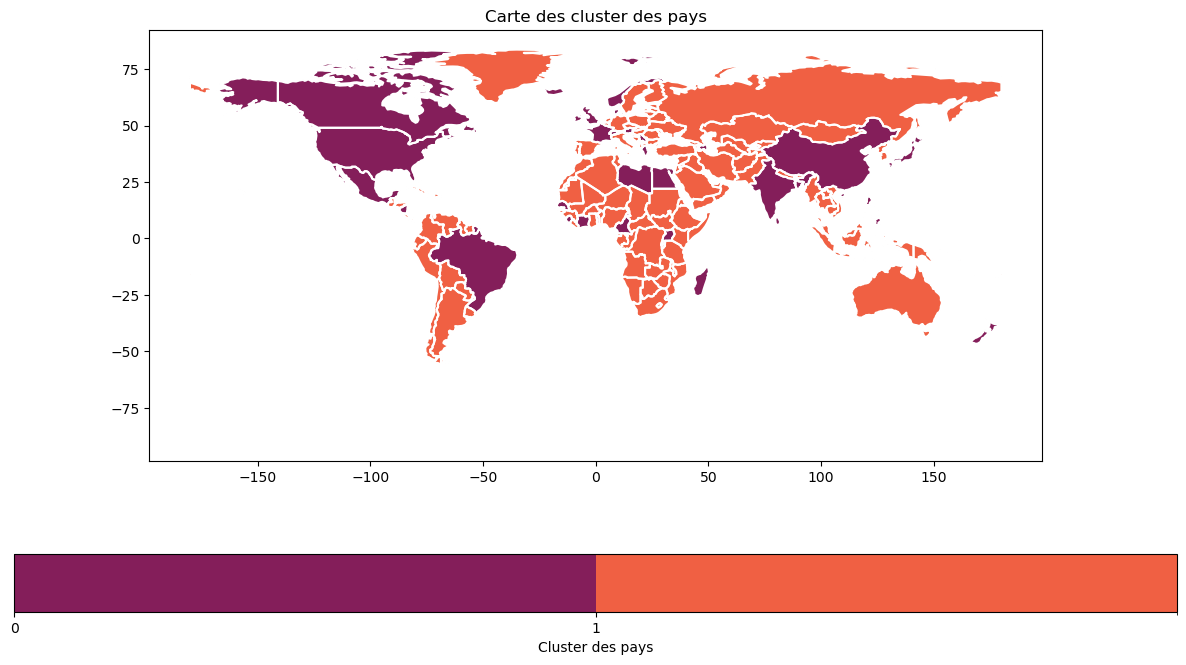

In [182]:
def plot_cluster_map(df, column, num_clusters, alpha3_col='Alpha-3'):
    # Charger une carte du monde
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Joindre les données des clusters avec les données géographiques
    world = world.merge(df, how='left', left_on='iso_a3', right_on=alpha3_col)

    # Obtenir les couleurs de la palette 'rocket' de seaborn
    colors = sns.color_palette('rocket', num_clusters)

    # Créer un ListedColormap avec ces couleurs
    cmap = mcolors.ListedColormap(colors)
    boundaries = list(range(num_clusters + 1))
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    # Créer la carte avec les clusters
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    world.boundary.plot(ax=ax, edgecolor='white')

    # Assurer que les clusters sont colorés selon leur numéro
    world.plot(column=column, ax=ax, legend=True,
               legend_kwds={'label': "Cluster des pays",
                            'orientation': "horizontal",
                            'ticks': list(range(num_clusters))},
               cmap=cmap, norm=norm)

    plt.title(f'Carte des {column} des pays')
    plt.show()

plot_cluster_map(df, column='cluster', num_clusters=optimal_k)

#### Nuages de mots pour les clusters

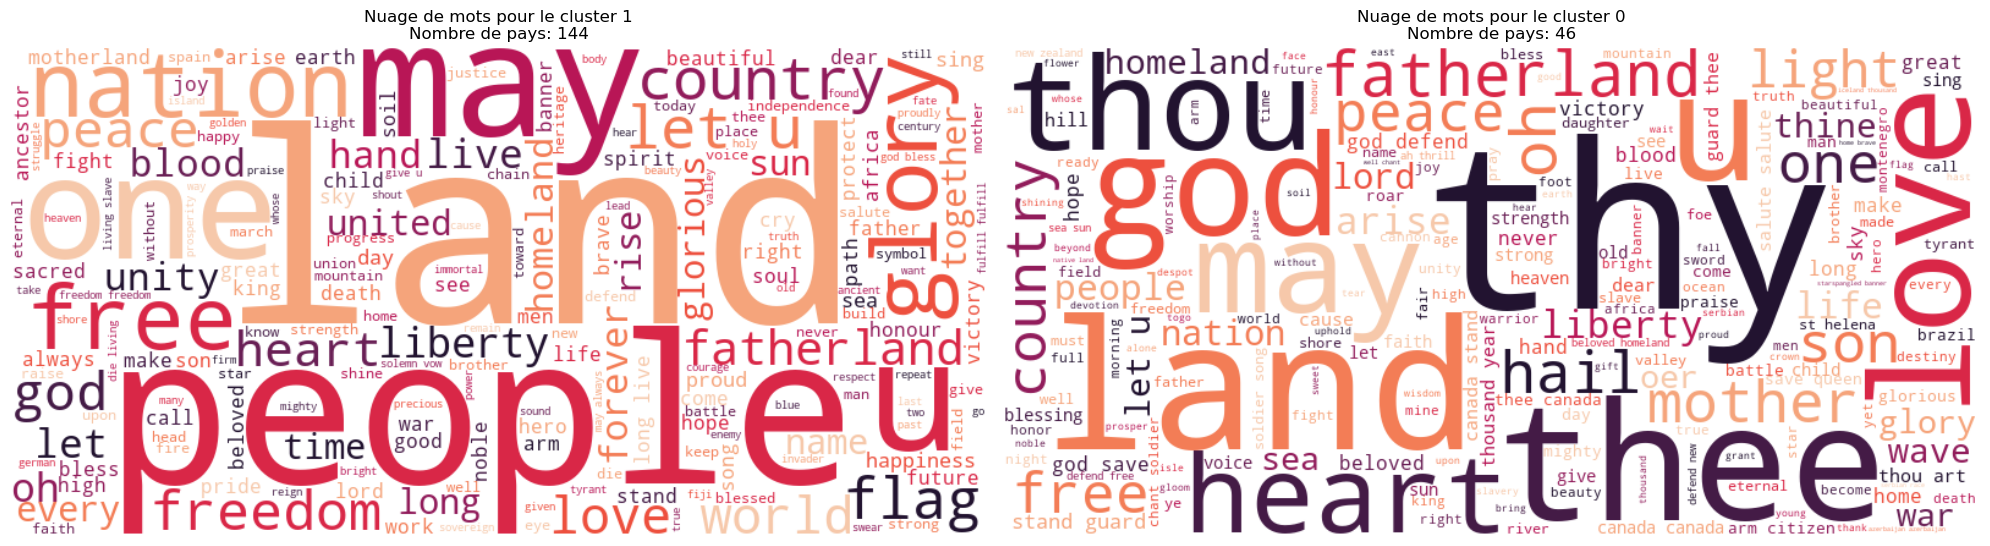

Les 7 mots les plus utilisés pour le cluster 1:
u: 196
land: 150
may: 124
people: 119
let: 115
one: 92
nation: 90


Les 7 mots les plus utilisés pour le cluster 0:
thy: 102
thee: 64
land: 63
god: 59
u: 53
thou: 38
love: 34




In [183]:
def generate_wordclouds(df, cluster_column, clusters_to_display=None, num_clusters=None):
    # Utiliser la palette de couleurs
    colors = sns.color_palette('rocket', 10)
    def random_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return tuple(int(c * 255) for c in random.choice(colors))

    # Créer une structure pour stocker les mots les plus fréquents par cluster
    most_common_words_by_cluster = {}

    # Obtenir les clusters uniques
    clusters = df[cluster_column].unique() if clusters_to_display is None else clusters_to_display
    if num_clusters is None:
        num_clusters = len(clusters)

    # Définir le nombre de graphiques par ligne
    num_cols = 2
    num_rows = (num_clusters + num_cols - 1) // num_cols

    # Créer les nuages de mots et compter les mots les plus fréquents par cluster
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten()

    for i, cluster in enumerate(clusters):
        cluster_data = df[df[cluster_column] == cluster]
        text = ' '.join(cluster_data['processed_anthem'])
        num_countries = len(cluster_data)

        # Créer et afficher le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=random_color_func).generate(text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'Nuage de mots pour le cluster {cluster}\nNombre de pays: {num_countries}')

        # Compter les occurrences des mots
        tokens = word_tokenize(text)
        word_counts = Counter(tokens)

        # Extraire les 7 mots les plus fréquents
        most_common_words = word_counts.most_common(7)
        most_common_words_by_cluster[cluster] = most_common_words

    # Supprimer les axes non utilisés
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Afficher les 7 mots les plus utilisés par cluster
    for cluster, words in most_common_words_by_cluster.items():
        print(f'Les 7 mots les plus utilisés pour le cluster {cluster}:')
        for word, count in words:
            print(f'{word}: {count}')
        print('\n')
        
generate_wordclouds(df, cluster_column='cluster', num_clusters=optimal_k)

#### Analyse par cluster pour k=2:

1. **Cluster 1**:

Les 7 mots les plus utilisés pour le cluster 1= u: 196 / land: 150 / may: 124 / people: 119 / let: 115 /one: 92 / nation: 90

Thèmes principaux:
* Unité et Nationalisme: Les mots comme "one", "nation", "people" et "land" indiquent un fort sentiment d'unité et de nationalisme dans les hymnes de ce cluster. Ces hymnes semblent célébrer la solidarité nationale et l'attachement au territoire.
* Espoir et Dévotion: Les mots "may" et "let" suggèrent des thèmes d'espoir et de dévotion, souvent présents dans les hymnes pour inspirer les citoyens et exprimer des aspirations pour le pays.
* Symboles et Valeurs: Les termes comme "flag", "freedom", et "glory" apparaissent également dans le nuage de mots, soulignant l'importance des symboles nationaux et des valeurs telles que la liberté et la gloire.

2. **Cluster 0**:

Les 7 mots les plus utilisés pour le cluster 0= thy: 102 / thee: 64 / land: 63 / god: 59 / u: 53 / thou: 38 / love: 34

Thèmes principaux:
* Langage Traditionnel et Poétique : Les mots "thy", "thee" et "thou" suggèrent que ce cluster d'hymnes utilise un langage archaïque et poétique, souvent associé à des contextes religieux ou historiques. Cela pourrait indiquer que ces hymnes sont plus anciens ou cherchent à évoquer un sentiment de solennité et de tradition.
* Thèmes Religieux : La fréquence élevée de "god" et les mots archaïques associés indiquent une forte présence de thèmes religieux dans ces hymnes. Ils peuvent invoquer la protection divine, remercier une entité divine ou exprimer des prières.
* Attachement au Territoire : Comme dans le cluster 1, le mot "land" souligne l'importance du territoire et de la patrie.
Dévotion et Affection : "Love" apparaît fréquemment, indiquant que ces hymnes expriment également des sentiments de dévotion et d'affection, que ce soit envers la patrie, une entité divine ou les deux.

#### Analyse par cluster pour optimal_k = 4:
**1. Cluster 2**

Les 7 mots les plus utilisés = u : 136 / may : 85 / let : 84 / people : 81 / land : 77 / free : 66 / glory : 64

Thèmes principaux :
* Espoir et Permission (may, let) : Les mots "may" et "let" suggèrent des thèmes d'espoir, de souhait et de permission. Ils sont souvent utilisés dans les contextes de souhaits pour la nation, de bénédictions ou de liberté.
* Peuple et Terre (people, land) : Ces mots mettent en avant l'importance du peuple et de la terre natale dans les hymnes de ce cluster.
* Liberté et Gloire (free, glory) : Ces hymnes valorisent la liberté et la gloire, probablement en lien avec des luttes pour l'indépendance ou des célébrations de victoires.



**2. Cluster 1**

Les 7 mots les plus utilisés = land : 75 / u : 62 / people : 44 / one : 44 / shall : 40 / may : 39 / heart : 33

Thèmes principaux :
* Unité et Identité (one, people) : L'accent est mis sur l'unité du peuple et de la nation, avec des références à la communauté et à l'identité collective.
* Terre et Coeur (land, heart) : La terre natale et le coeur symbolisent un profond attachement émotionnel et patriotique.
* Futur et Destin (shall, may) : Les termes "shall" et "may" indiquent des perspectives futures, des promesses ou des prophéties pour la nation.



**3. Cluster 3**

Les 7 mots les plus utilisés = thy : 96 / god : 63 / land : 57 / thee : 52 / u : 44 / love : 33 / thou : 30

Thèmes principaux :
* Dévotion Religieuse (god, thy, thee, thou) : Ce cluster a une forte composante religieuse, avec des références fréquentes à Dieu et des termes archaïques de dévotion.
* Terre et Amour (land, love) : Il y a une célébration de la terre natale et un sentiment profond d'amour pour la patrie.
* Identité Personnelle (u) : Comme dans d'autres clusters, "u" représente une référence fréquente à l'identité personnelle et nationale.



**4. Cluster 0**

Les 7 mots les plus utilisés = fatherland : 20 / german : 13 / shall : 9 / beloved : 7 / god : 7 / u : 7 / war : 6

Thèmes principaux :
* Patriotisme et Identité Nationale (fatherland, german) : Ce cluster met fortement en avant le patriotisme et l'identité nationale spécifique (ex. Allemagne).
* Dévotion et Loyauté (beloved, god) : Il y a des éléments de dévotion et de loyauté envers la nation et Dieu.
* Futur et Conflit (shall, war) : Les termes "shall" et "war" suggèrent des thèmes de futur et de conflit, probablement en lien avec des luttes historiques ou des aspirations futures.



##### Conclusion
Les hymnes des différents clusters révèlent des thèmes variés allant de la dévotion religieuse et patriotique à des aspirations de liberté et d'unité. Chaque cluster a ses propres caractéristiques distinctes :

* **Cluster 2** : Espoir, liberté, et gloire.
* **Cluster 1** : Unité, identité, et destin.
* **Cluster 3** : Dévotion religieuse, amour pour la patrie.
* **Cluster 0** : Patriotisme spécifique, loyauté, et conflit.


## 3- Partitionnement Hiérarchique

### Appliquer le clustering hiérarchique et représenter le dendrogramme

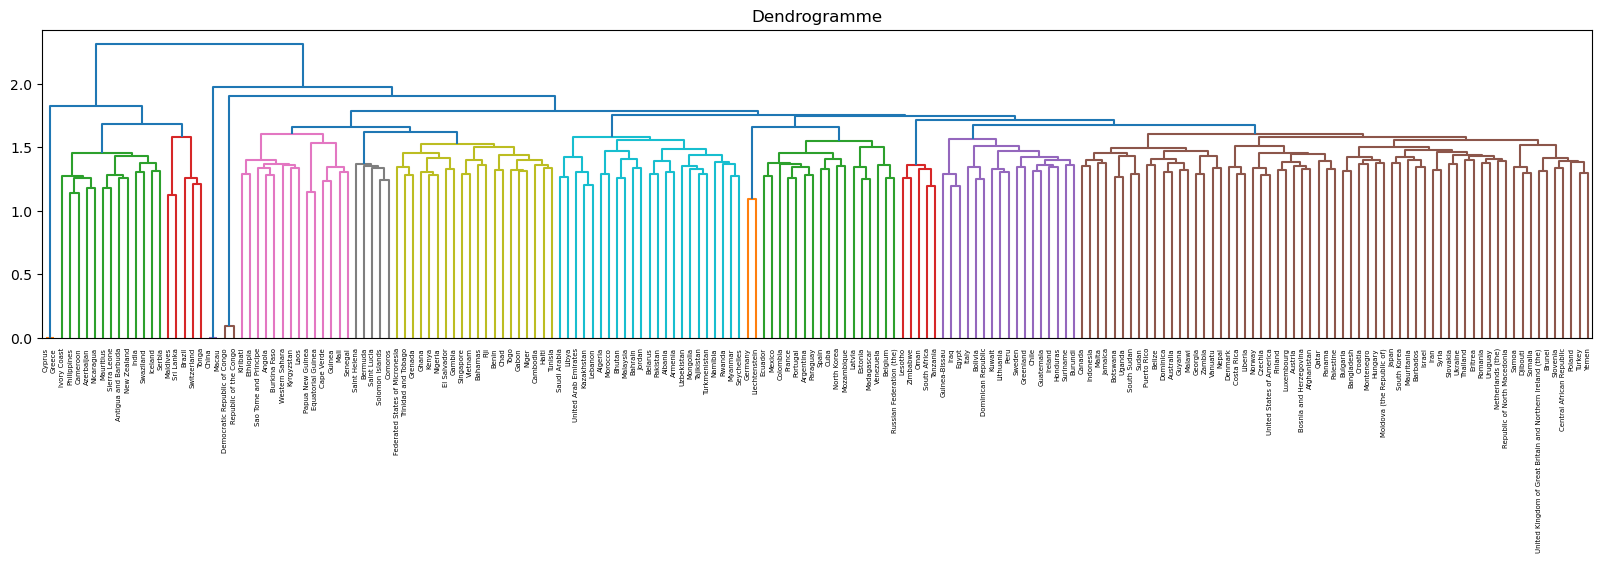

In [184]:
df = df.set_index("Country")

def plot_dendrogram(X, labels, threshold=None):
    # Calculer le linkage
    # linkage : méthode utilisée pour déterminer comment fusionner les clusters de manière hiérarchique via le calcul de la distance entre 
    # ensembles de points (clusters) lors de la construction du dendrogramme. 
    Z = linkage(X.toarray(), 'ward')

    # Tracer le dendrogramme
    plt.figure(figsize=(20, 4))
    plt.title("Dendrogramme")
    dendrogram(Z, labels=labels)

    # Tracer la ligne horizontale à la hauteur de découpe si un seuil est donné
    if threshold is not None:
        plt.axhline(y=threshold, color='r', linestyle='--')
    
    plt.show()

plot_dendrogram(X, df.index.values)

On voit ici que Cyprus & Greece + China & Macau + Democratic Republic of Congo & Republic of Congo s'individualisent très rapidement des autres hymnes.

In [185]:
d_congo_observation = df.loc['Democratic Republic of Congo', 'processed_anthem']
print(d_congo_observation)

congo_observation = df.loc['Republic of the Congo', 'processed_anthem']
print(congo_observation)

china_observation = df.loc['China', 'processed_anthem']
print(china_observation)

macau_observation = df.loc['Macau', 'processed_anthem']
print(macau_observation)

greece_observation = df.loc['Greece', 'processed_anthem']
print(greece_observation)

cyprus_observation = df.loc['Cyprus', 'processed_anthem']
print(cyprus_observation)

day sun rise congo stand resplendent long night ended great happiness come let u wild joyfulness sing song freedom arise congolese proud every man proclaim unity nation let u forget divide u become united ever let u live motto unity work progress forest bush bush ocean one people one soul one heart ardent proud let u fight every one u old black country die really matter child everywhere able say triumph come battle smallest village sing beneath three colour
day sun rise congo stand resplendent long night ended great happiness come let u wild joyfulness sing song freedom arise congolese proud every man proclaim unity nation let u forget divide u become united ever let u live motto unity work progress forest bush bush ocean one people one soul one heart ardent proud let u fight every one u black country die really matter child everywhere able say triumph come battle smallest village sing beneath three colour
arise ye refuse slave flesh blood let u build new great wall people china critic

Pour ces paires de pays, on a le même hymne (normal ?)

=> Pour faire un traitement global mais considérer ces observations comme des anomalies, on va ajouter 3 clusters (un pour la Chine, un pour Chyore et un pour les Républiques du Congo). Il faut cependant réévaluer le nombre de clusters sans être influencé par ces anomalies = on va enlever les anomalies puis réappliquer les méthodes du coude et silhouette pour voir si on obtient un nombre de cluster k plus évident.

In [186]:
anomalies = ['Democratic Republic of Congo', 'Republic of the Congo', 'China', 'Macau', 'Greece', 'Cyprus']
df_without_anomalies = df[~df.index.isin(anomalies)]
print(df.shape)
print(df_without_anomalies.shape)

(190, 8)
(184, 8)


In [187]:
# Revectoriser les données sans les anomalies
vectorizer = TfidfVectorizer()
X_without_anomalies = vectorizer.fit_transform(df_without_anomalies['processed_anthem'])

### **Méthode du coude** sans les anomalies

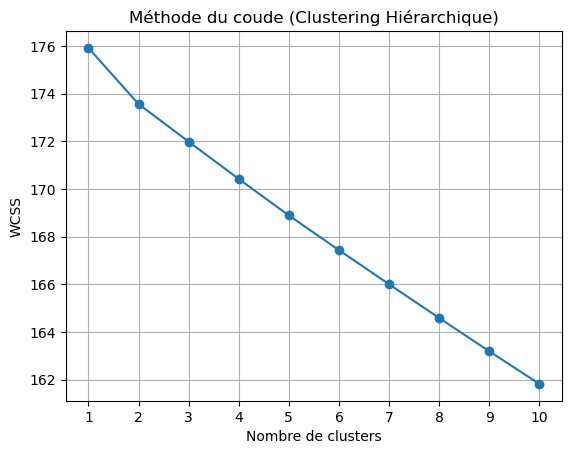

In [188]:
def plot_elbow_method_hierarchical(X, max_clusters=10):
    # Convertir la matrice en format dense si nécessaire
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    wcss = []
    Z = linkage(X, method='ward')

    for k in range(1, max_clusters + 1):
        labels = fcluster(Z, k, criterion='maxclust')
        cluster_centers = []
        for j in range(1, k + 1):
            cluster_points = X[labels == j]
            cluster_center = cluster_points.mean(axis=0)
            cluster_centers.append(cluster_center)
        inertia = sum(np.sum((X[labels == j] - cluster_centers[j - 1]) ** 2) for j in range(1, k + 1))
        wcss.append(inertia)

    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Méthode du coude (Clustering Hiérarchique)')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('WCSS')
    plt.xticks(np.arange(1, max_clusters + 1, step=1))  # Assure que les marques sur l'axe des x sont pour chaque valeur de k
    plt.grid(True)
    plt.show()

plot_elbow_method_hierarchical(X_without_anomalies)


On peut toujourds partir sur k=2 mais dans un soucis de diversité avec l'analys précédente, nous allons essayer de choisr un k=4 auquel on ajoute 3 à cause des anomalies qui s'individualisent très rapidement des autres hymnes.

### **Méthode silhouette** sans les anomalies

In [189]:

# * Doesn't work without normalization

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage, fcluster
# from sklearn.metrics import silhouette_score

# def plot_silhouette_method_hierarchical(X, max_clusters=10):
#     # Convertir la matrice en format dense si nécessaire
#     if hasattr(X, "toarray"):
#         X = X.toarray()
    
#     silhouette_scores = []
#     Z = linkage(X, method='ward')

#     for k in range(2, max_clusters + 1):
#         labels = fcluster(Z, k, criterion='maxclust')
#         score = silhouette_score(X, labels)
#         silhouette_scores.append(score)

#     plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
#     plt.title('Méthode silhouette (Clustering Hiérarchique)')
#     plt.xlabel('Nombre de clusters')
#     plt.ylabel('Score silhouette')
#     plt.xticks(np.arange(2, max_clusters + 1, step=1))  # Assure que les marques sur l'axe des x sont pour chaque valeur de k
#     plt.grid(True)
#     plt.show()

# # Exemple d'utilisation de la fonction
# # Assurez-vous que X_without_anomalies est votre matrice de caractéristiques sans anomalies
# plot_silhouette_method_hierarchical(X_without_anomalies, 100)


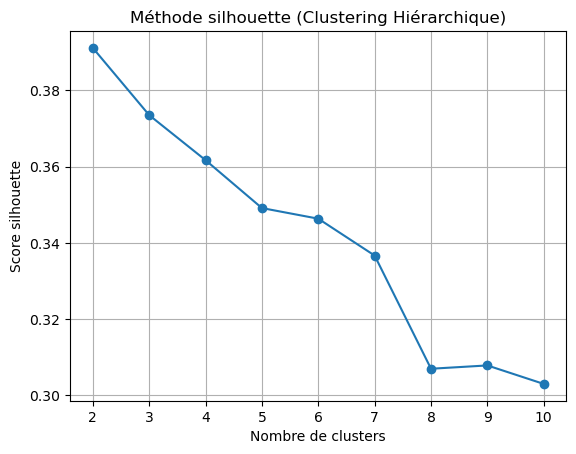

In [190]:
def plot_silhouette_method_hierarchical(X, max_clusters=10):
    # Convertir la matrice en format dense si nécessaire
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    # Normaliser les données (sans normalisation: courbe silhouette croissante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    silhouette_scores = []
    Z = linkage(X_scaled, method='ward')

    for k in range(2, max_clusters + 1):
        labels = fcluster(Z, k, criterion='maxclust')
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
        # print(f"Nombre de clusters: {k}, Score silhouette: {score}")

    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Méthode silhouette (Clustering Hiérarchique)')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score silhouette')
    plt.xticks(np.arange(2, max_clusters + 1, step=1))  # Assure que les marques sur l'axe des x sont pour chaque valeur de k
    plt.grid(True)
    plt.show()

plot_silhouette_method_hierarchical(X_without_anomalies)

On peut toujourds partir sur k=2 mais dans un soucis de diversité avec l'analys précédente, nous allons essayer de choisr un k=4 auquel on ajoute 3 à cause des anomalies qui s'individualisent très rapidement des autres hymnes.

In [191]:

#! Target number of clusters
optimal_k = 7

### Estimer le seuil pour le dendogramme

In [192]:
def find_optimal_cut_height(Z, target_clusters, start, end, step):
    heights = np.arange(start, end, step)
    for h in heights:
        clusters = fcluster(Z, h, criterion='distance')
        num_clusters = len(np.unique(clusters))
        print(f"Hauteur de découpe: {h}, Nombre de clusters: {num_clusters}")
        if num_clusters == target_clusters:
            break
    
    optimal_height = h
    return optimal_height

# Exemple d'utilisation
# Supposons que Z soit déjà calculé avec linkage(X, method='ward')
Z = linkage(X.toarray(), method='ward')
start = 1.7
end = 1.8
step = 0.01

optimal_height = find_optimal_cut_height(Z, optimal_k, start, end, step)

Hauteur de découpe: 1.7, Nombre de clusters: 9
Hauteur de découpe: 1.71, Nombre de clusters: 9
Hauteur de découpe: 1.72, Nombre de clusters: 8
Hauteur de découpe: 1.73, Nombre de clusters: 8
Hauteur de découpe: 1.74, Nombre de clusters: 8
Hauteur de découpe: 1.75, Nombre de clusters: 7


=> Seuil à sélectionner : 1.75

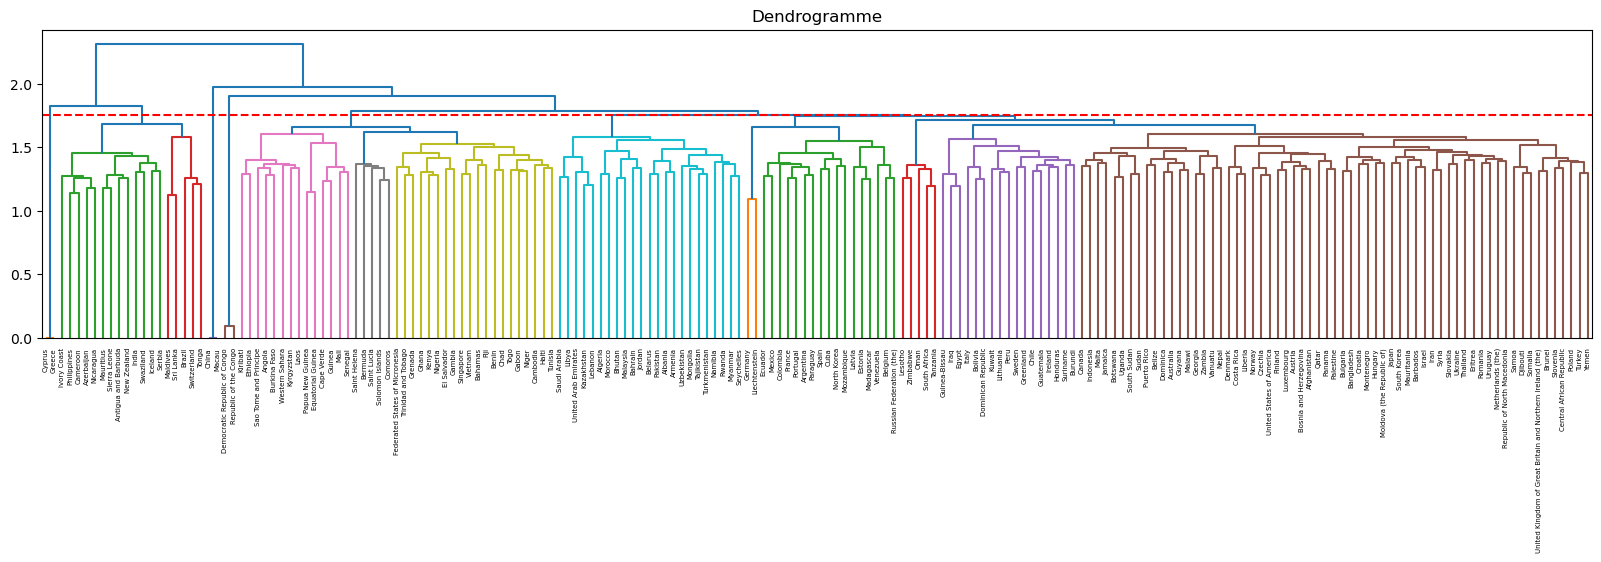

In [193]:
plot_dendrogram(X, df.index.values, optimal_height)

#### Attribuer un hierarchical_cluster à chaque observation en fonction du nombre idéal de clusters (optimal_k)

In [194]:
# Attribuer un hierarchical_cluster à chaque observation en fonction du nombre idéal de hierarchical_clusters (optimal_k)
df['hierarchical_cluster'] = fcluster(Z, optimal_k, criterion='maxclust')

# Vérifier les valeurs possibles pour les hierarchical_cluster
unique_clusters = np.unique(df['hierarchical_cluster'])

# # Vérifier le nombre de hierarchical_cluster
print(f"Nombre de clusters: {len(unique_clusters)}")
print(f"Clusters: {unique_clusters}")

Nombre de clusters: 7
Clusters: [1 2 3 4 5 6 7]


#### Représentation via la PCA

In [195]:
# Détermoner le nombre de PC qui permet de maintenir une bonne variance cumulée

num_components = optimal_number_of_components(X, variance_threshold=0.8)
print("🚀 ~ num_components:", num_components)

🚀 ~ num_components: 128


Même si les deux premières composantes principales (PC1 et PC2) n'expliquent pas la majorité de la variance, elles peuvent toujours fournir une vue utile des clusters dans les données. La visualisation des premières composantes principales peut aider à identifier des patterns et des clusters qui ne seraient pas immédiatement évidents autrement. Si les premières composantes principales montrent une bonne séparation des clusters, elles peuvent être utilisées pour des analyses ultérieures ou des visualisations intuitives.

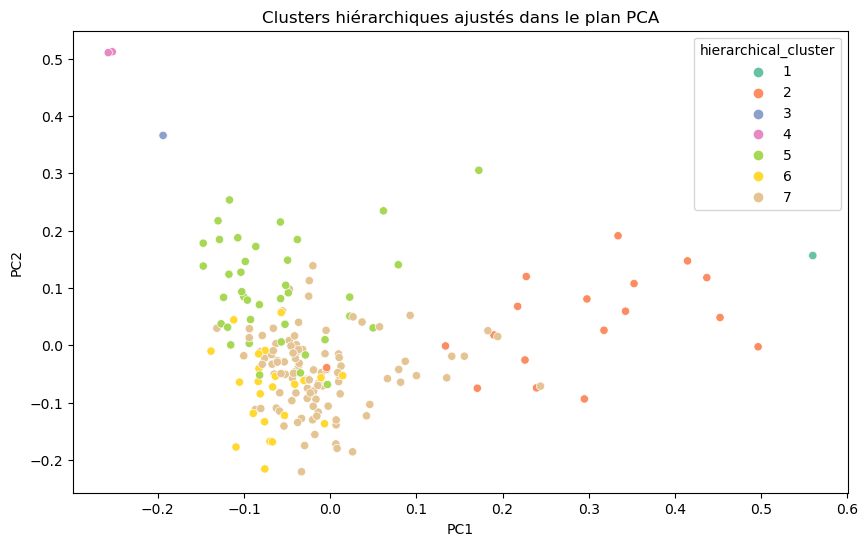

In [196]:
# Appliquer PCA pour réduire les données à `num_components` dimensions
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(X.toarray())

# Ajouter les composantes principales au dataframe
df['hierarchical_PC1'] = principal_components[:, 0] # changer 0 par un autre nombre pour choisir la dimension
df['hierarchical_PC2'] = principal_components[:, 1] # changer 1 par un autre nombre pour choisir la dimension

# Tracer les clusters hiérarchiques ajustés dans le plan PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='hierarchical_PC1', y='hierarchical_PC2', hue='hierarchical_cluster', palette='Set2')
plt.title('Clusters hiérarchiques ajustés dans le plan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

##### Pour k=4 + 3 anomalies

Les clusters 1, 3 et 4 semblent être liés aux "anomalies".
Le cluster 2 est plus dispersé, ce qui peut indiquer une variabilité plus grande parmi les observations de ce groupe. = moins bien regroupées.
Les points des clusters 5, 6 et 7 sont principalement regroupés au centre, ce qui montre une certaine cohésion, bien que certains points soient légèrement plus éloignés.

=> Globalement, le clustering semble cohérent.

##### Pour k=2

Le cluster 1 est dispersé mais se concentre à droite. Le cluster 0 se concentre à gauche mais est moins dispersif.


### Représentations

#### Répartition des k clusters au sein des continents

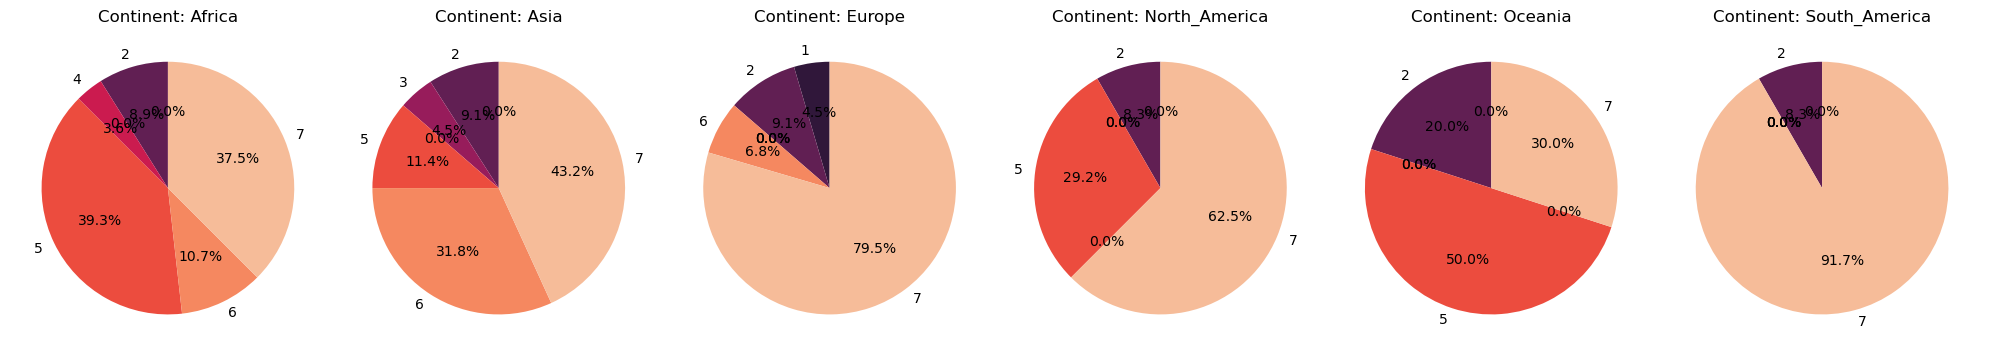

In [197]:
plot_piecharts(df, unit_col_pie='Continent', freq_col_pie='hierarchical_cluster', num_cols=6, palette='rocket')

#### Répartition des continents au sein des k clusters

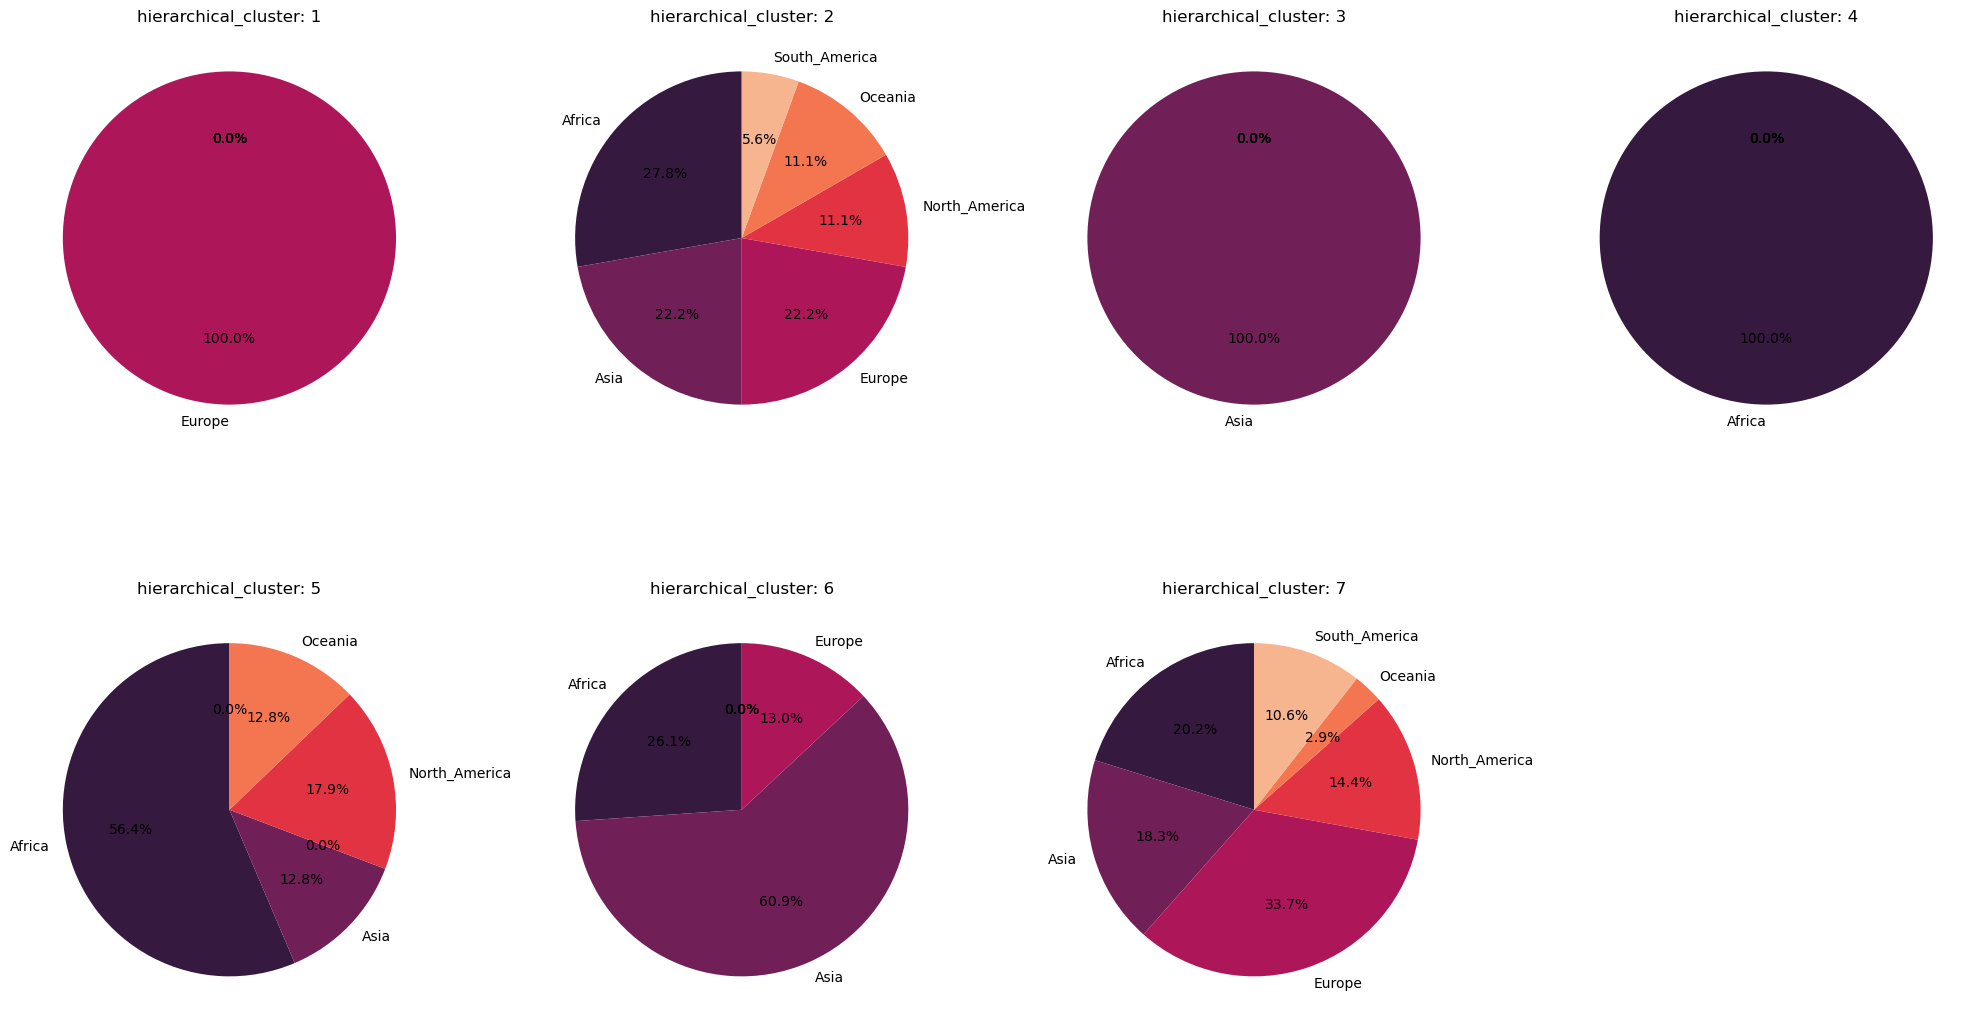

In [198]:
plot_piecharts(df, unit_col_pie='hierarchical_cluster', freq_col_pie='Continent', num_cols=4, palette='rocket')

3 piecharts avec peu de diversité = anomalies ?

##### si k= 7 (Identification des anomalies)

In [199]:
# Filtrer les pays avec un hierarchical_cluster de 1
cluster_1_countries = df[df['hierarchical_cluster'] == 1]

# Afficher les résultats
print(cluster_1_countries.index.tolist())
print("______________________________")

# Filtrer les pays avec un hierarchical_cluster de 3
cluster_3_countries = df[df['hierarchical_cluster'] == 3]

# Afficher les résultats
print(cluster_3_countries.index.tolist())
print("______________________________")

# Filtrer les pays avec un hierarchical_cluster de 4
cluster_4_countries = df[df['hierarchical_cluster'] == 4]

# Afficher les résultats
print(cluster_4_countries.index.tolist())
print("______________________________")



['Cyprus', 'Greece']
______________________________
['China', 'Macau']
______________________________
['Democratic Republic of Congo', 'Republic of the Congo']
______________________________


=> Il s'agit des anomalies relevées plus tôt = moins intéressantes car moins d'hymnes comparés + hymnes très similaires (voire identiques).

On va surtout s'intéresser aux clusters 2, 5, 6 et 7.

#### Carte de la répartition des clusters dans le monde

/var/folders/1k/1sj3zxpx1x78x8blphwrrcrc0000gn/T/ipykernel_34610/4229449231.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


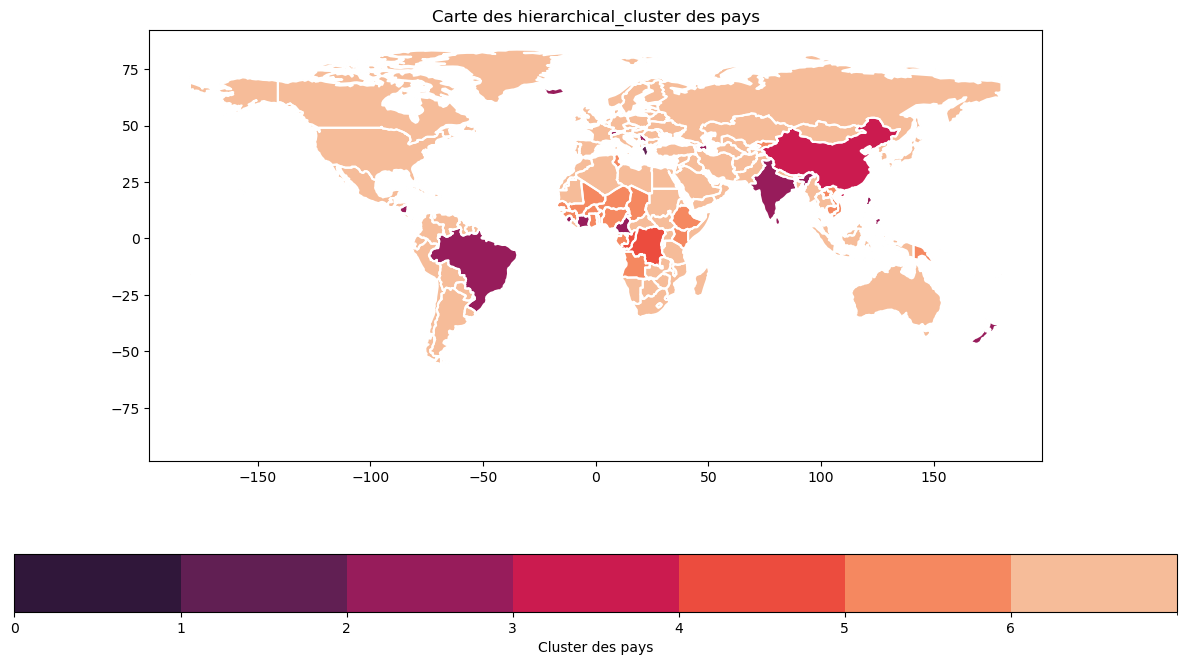

In [200]:
plot_cluster_map(df, column='hierarchical_cluster', num_clusters=optimal_k)

#### Nuages de mots pour les clusters ne représentant pas les anomalies.

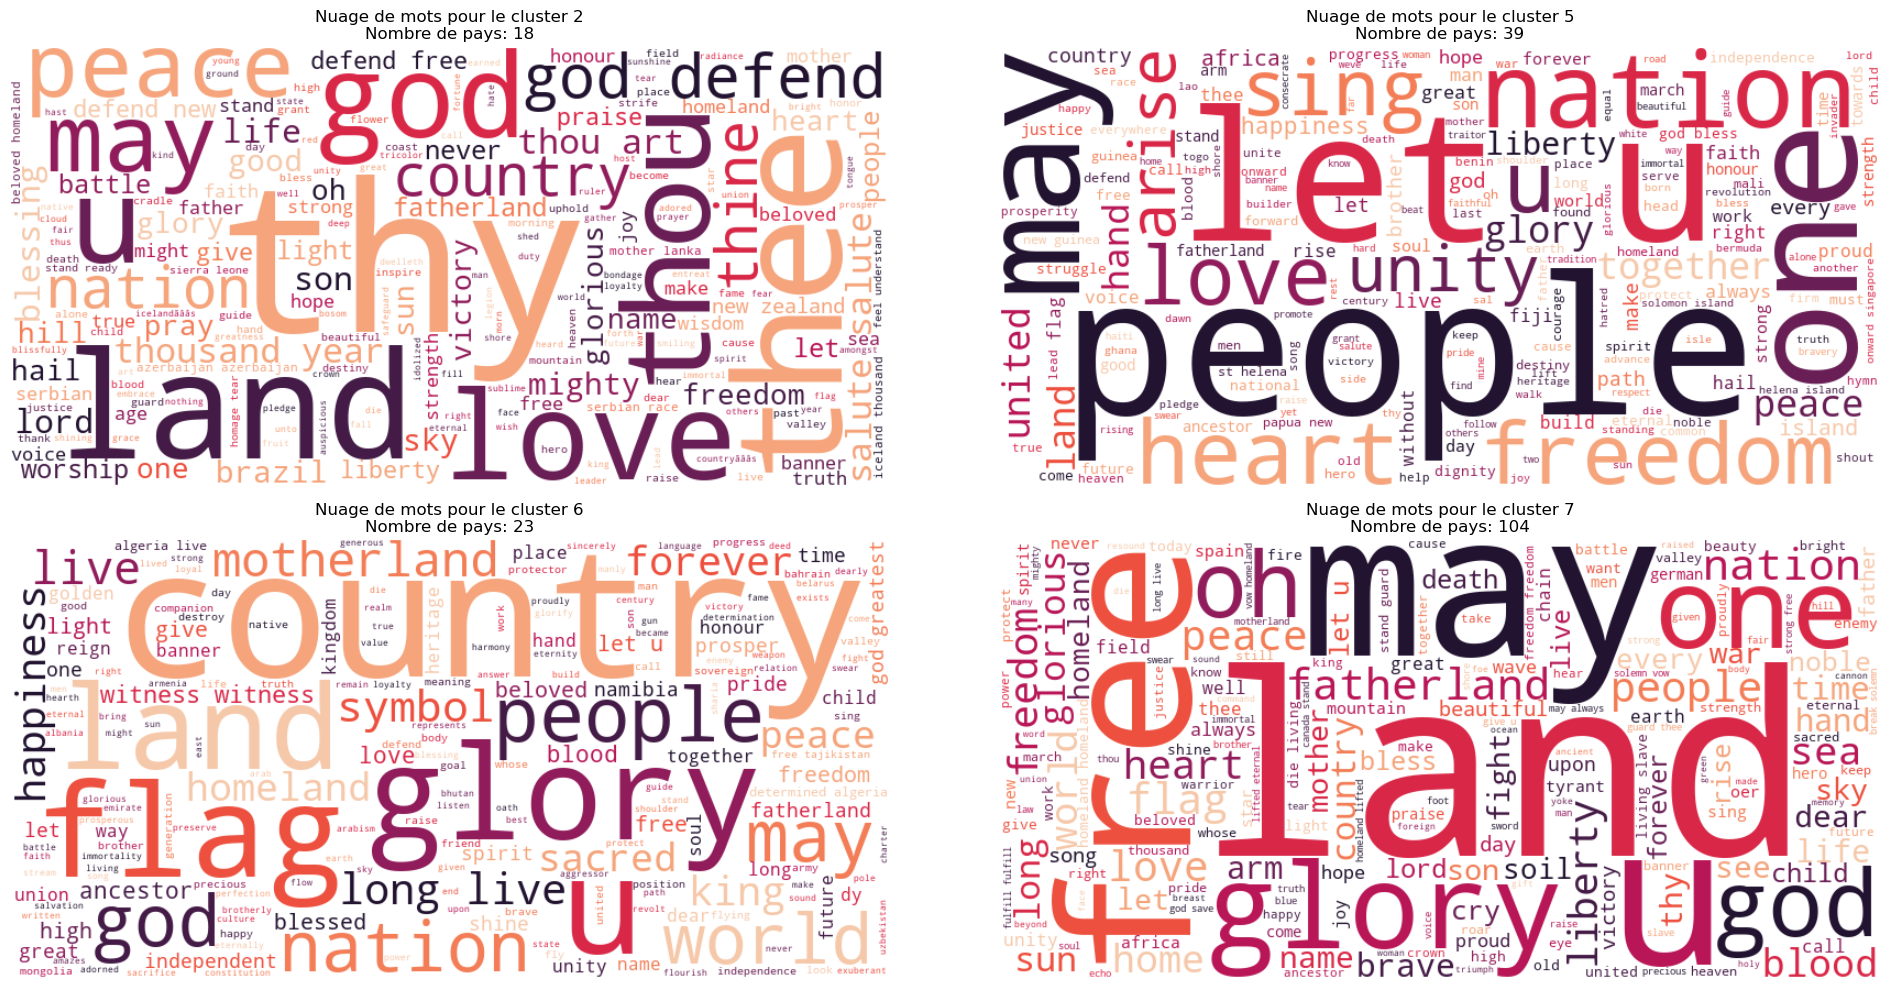

Les 7 mots les plus utilisés pour le cluster 2:
thy: 74
thee: 32
land: 32
thou: 29
god: 29
love: 21
u: 20


Les 7 mots les plus utilisés pour le cluster 5:
u: 73
let: 63
people: 58
one: 34
may: 29
nation: 29
heart: 23


Les 7 mots les plus utilisés pour le cluster 6:
country: 40
u: 27
live: 25
glory: 20
flag: 19
god: 19
land: 16


Les 7 mots les plus utilisés pour le cluster 7:
land: 149
u: 115
may: 98
free: 79
shall: 67
homeland: 67
god: 65




In [201]:
# Définir les clusters à afficher quand k = 7
clusters_to_display = [2, 5, 6, 7]

generate_wordclouds(df, cluster_column='hierarchical_cluster', clusters_to_display=clusters_to_display, num_clusters=len(clusters_to_display))

#### **Analyse pour k=7**

1. **Cluster 2**

Mots les plus utilisés : thy, thee, land, thou, god, love, u

* Thème religieux et dévotion : Les mots "thy", "thee", "god", et "thou" suggèrent un ton religieux et dévot. Ces hymnes semblent mettre l'accent sur la dévotion divine et la spiritualité.
* Amour et affection : Le mot "love" indique un thème d'affection, possiblement envers la patrie ou une figure divine.
* Référence à la terre : "Land" est également un mot fréquent, suggérant une forte connexion avec la patrie.

2. **Cluster 5**

Mots les plus utilisés : u, let, people, one, may, nation, heart

* Unité et peuple : Les mots "people", "one", et "nation" suggèrent un thème d'unité nationale et de collectif. Ces hymnes célèbrent probablement le peuple et l'unité nationale.
* Espoir et avenir : "May" et "let" impliquent des souhaits et des aspirations pour l'avenir, indiquant un ton optimiste et inspirant.
* Émotion et passion : "Heart" ajoute une dimension émotionnelle, mettant en avant la passion et l'amour pour la patrie.

3. **Cluster 6**

Mots les plus utilisés : country, u, live, glory, flag, god, land

* Patriotisme et nationalisme : "Country", "flag", et "land" montrent un fort sentiment de patriotisme et d'attachement à la nation.
* Vie et gloire : Les mots "live" et "glory" suggèrent une célébration de la vie et de la gloire de la nation, possiblement en commémorant des héros ou des événements historiques importants.
* Référence divine : "God" indique une présence de thèmes religieux, mais moins prédominante que dans le Cluster 2.

4. **Cluster 7**

Mots les plus utilisés : land, u, may, free, shall, homeland, god

* Liberté et patrie : "Free", "land", et "homeland" mettent en avant les thèmes de la liberté et de l'amour pour la patrie. Ces hymnes sont probablement très patriotiques et exaltent la liberté nationale.
* Aspirations et futur : "May" et "shall" indiquent des souhaits et des promesses pour l'avenir, ce qui donne un ton de détermination et de vision pour le futur.
* Dimension religieuse : "God" apparaît encore, suggérant une reconnaissance de l'aide divine dans l'histoire ou les aspirations de la nation.

#### Nuages de mots pour les clusters représentant les anomalies.

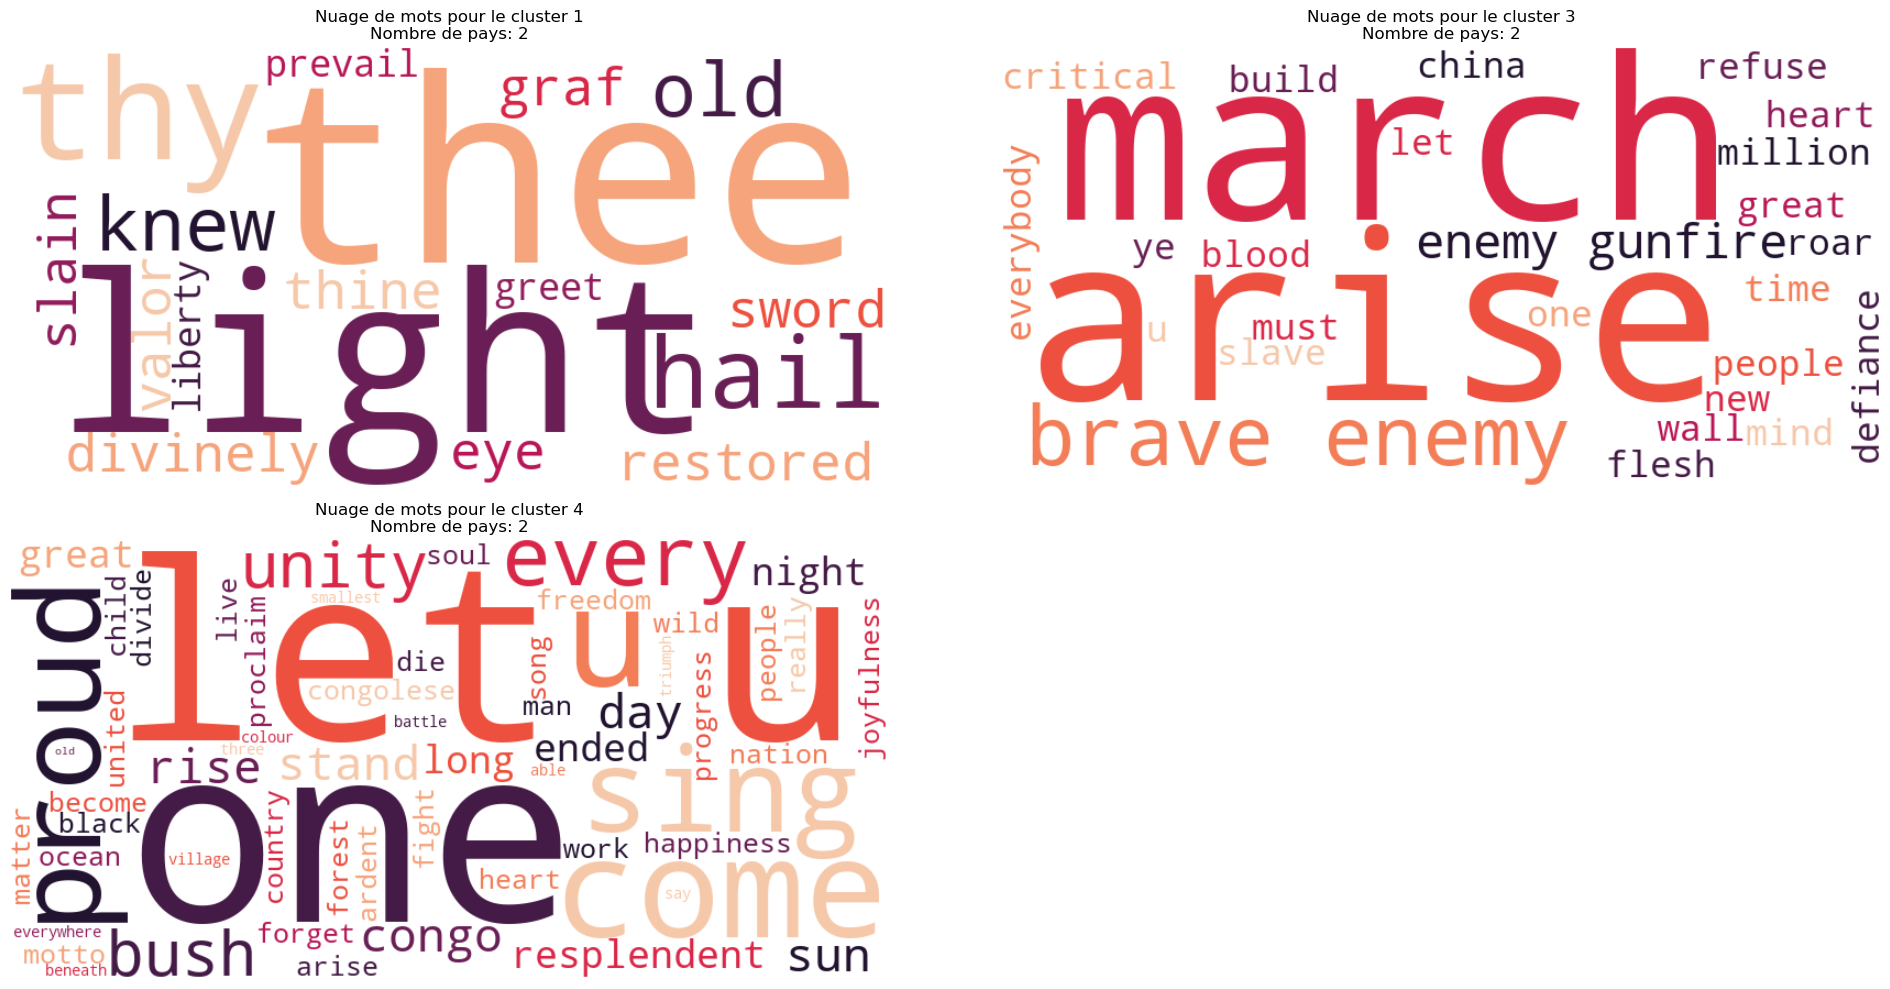

Les 7 mots les plus utilisés pour le cluster 1:
thee: 4
light: 4
thy: 4
hail: 4
knew: 2
old: 2
divinely: 2


Les 7 mots les plus utilisés pour le cluster 3:
arise: 8
march: 8
brave: 4
enemy: 4
gunfire: 4
ye: 2
refuse: 2


Les 7 mots les plus utilisés pour le cluster 4:
u: 12
let: 8
one: 8
come: 4
sing: 4
proud: 4
every: 4




In [202]:
anomalies_cluster = [1, 3, 4]

generate_wordclouds(df, cluster_column='hierarchical_cluster', clusters_to_display=anomalies_cluster, num_clusters=len(anomalies_cluster))

# 1 ['Cyprus', 'Greece']
# ______________________________
# 3 ['China', 'Macau']
# ______________________________
# 4 ['Democratic Republic of Congo', 'Republic of the Congo']
# ______________________________
